# ActiveLLM demo
Use a generative LLM in an active learning loop. Since an active learning loop it very compute intensive, it is recommended to run this notebook in Google Colab: <a target="_blank" href="https://colab.research.google.com/github/MoritzLaurer/ActiveLLM/blob/main/ActiveLLM_demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


## Install and load relevant packages

In [ ]:
%pip install "transformers[sentencepiece]~=4.28"
%pip install "datasets~=2.8"
%pip install accelerate==0.18
#%pip install "argilla[server, listeners]==1.1.1"

In [2]:
# get the code for the active learning loop from github
!rm -rf ActiveLLM  # delete directory in case it was previously imported and updates were made
!git clone https://github.com/MoritzLaurer/ActiveLLM

Cloning into 'ActiveLLM'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 21 (delta 8), reused 11 (delta 5), pack-reused 0
Unpacking objects: 100% (21/21), 63.55 KiB | 644.00 KiB/s, done.


In [3]:
# info on the GPU you are using
!nvidia-smi
# info on available ram
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('\n\nYour runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Tue Apr 25 11:21:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
## import relevant packages
import numpy as np
import pandas as pd
import torch
import datasets
import copy

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, 
    AutoConfig, AutoModelForNextSentencePrediction, T5ForConditionalGeneration,
    TrainingArguments, Trainer
)

from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, accuracy_score, classification_report
from sklearn.model_selection import train_test_split


In [6]:
## load/reload modules
import sys
sys.path.insert(0, os.getcwd())
from ActiveLLM.active_learner import ActiveLearner
# reload in case of updates in active_learner.py
import importlib
from ActiveLLM import active_learner
importlib.reload(active_learner)
from ActiveLLM.active_learner import ActiveLearner


## Set main arguments

In [7]:
DATASET = "squad_v2"
MODEL_NAME = "google/flan-t5-small"  
METHOD = "generative"
MAX_SAMPLE = 10_000
N_SAMPLE_AL = 50
N_ITER_MAX = 20
DATE = 20230425
SEED_GLOBAL = 42
np.random.seed(SEED_GLOBAL)


In [8]:
HYPER_PARAMS_DIC = {
    'lr_scheduler_type': 'linear', 'learning_rate': 5e-4, 'num_train_epochs': 5, 'seed': SEED_GLOBAL, 
    'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8*2, 
    'warmup_ratio': 0.30, 'weight_decay': 0.01,
    "include_inputs_for_metrics": True,
    # ! need to set this to true, otherwise seq2seq-trainer is not used https://github.com/huggingface/transformers/blob/v4.28.1/src/transformers/trainer_seq2seq.py#L246
    "predict_with_generate": True,
    "gradient_checkpointing": True,
    #"gradient_accumulation_steps": 2,
}
MODEL_MAX_LENGTH = 512 - 128
TRAINING_DIRECTORY = ""


## Load and clean data

In [9]:
## load data
if "squad_v2" in DATASET:
    from datasets import load_dataset
    dataset_squad_v2 = load_dataset("squad_v2")
    # dataset to df for easier processing
    df_train = dataset_squad_v2["train"].to_pandas()
    df_test = dataset_squad_v2["validation"].to_pandas()
    # create label_text column and clean values
    df_train["label_text"] = df_train["answers"].apply(lambda x: x["text"][0] if len(x["text"]) > 0 else "unanswerable" )
    df_test["label_text"] = df_test["answers"].apply(lambda x: x["text"][0] if len(x["text"]) > 0 else "unanswerable" )
else:
    raise Exception(f"Dataset name not found: {DATASET}")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

Dataset squad_v2 downloaded and prepared to /root/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
# sample training data
if "squad_v2" in DATASET:
    df_corpus = df_train
    
# make datasets smaller for testing:
if MAX_SAMPLE:
    df_corpus = df_corpus.sample(n=MAX_SAMPLE, random_state=SEED_GLOBAL)
    df_test = df_test.sample(n=int(MAX_SAMPLE/2), random_state=SEED_GLOBAL)

print(df_corpus.label_text.value_counts())


unanswerable                                                           3266
three                                                                    22
two                                                                      16
four                                                                     15
six                                                                      11
                                                                       ... 
University of Pennsylvania, Temple University and Drexel University       1
proto-dentistry                                                           1
eternal life in heaven after the body’s death                             1
James Bruce                                                               1
silver thaws                                                              1
Name: label_text, Length: 6161, dtype: int64


In [11]:
# instruction formatting of QA task
if DATASET == "squad_v2":
        df_corpus["text_prepared"] = "Context: " + df_corpus["context"] + "\n\nQuestion: " + df_corpus["question"] + "\n\nExtract the answer from the context. Extracted answer: "
        df_test["text_prepared"] = "Context: " + df_test["context"] + "\n\nQuestion: " + df_test["question"] + "\n\nExtract the answer from the context. Extracted answer: "
else:
    raise NotImplementedError


In [12]:
print(df_corpus["label_text"].str.len().max())
df_corpus[["text_prepared", "label_text"]].head()


202


,text_prepared,label_text
125137,Context: It threatened the collapse of large f...,2012
30275,Context: But house was also being developed on...,Amnesia
39176,Context: Although Calvin and Huldrych Zwingli ...,unanswerable
32129,Context: Due to extreme variation in elevation...,varies from hot and subhumid tropical
44136,Context: The Queen addressed the United Nation...,unanswerable


## Set up the active learner

In [13]:
learner = ActiveLearner(seed=SEED_GLOBAL)

learner.load_pd_dataset(df_corpus=df_corpus, df_test=df_test, text_column="text_prepared", label_column="label_text", separate_testset=True)  

In [14]:
from transformers import GenerationConfig
# docs https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/text_generation#transformers.GenerationMixin.generate
config_params = {
    "max_new_tokens": 16,
    "num_beams": 2,
    #"generation_num_beams": 5,  # https://github.com/huggingface/transformers/blob/68287689f2f0d8b7063c400230b3766987abf18d/src/transformers/training_args_seq2seq.py#L42
    "num_return_sequences": 1,
    "temperature": 0,  # default: 1.0
    "top_k": 50,  # default: 50
    "return_dict_in_generate": True,
    "output_scores": True,
    #"predict_with_generate": False,
    #"include_inputs_for_metrics": True
    "renormalize_logits": "True",
}
# seq2seq trainer seems to fully ignore the config in eval-loop outputs into compute_metrics. 
# probably because of: https://github.com/huggingface/transformers/blob/v4.28.1/src/transformers/trainer_seq2seq.py#L273
# the function that determines the input for compute_metrics: 
# https://github.com/huggingface/transformers/blob/68287689f2f0d8b7063c400230b3766987abf18d/src/transformers/trainer.py#L280
# compute metrics function: 
# https://github.com/huggingface/transformers/blob/68287689f2f0d8b7063c400230b3766987abf18d/src/transformers/trainer.py#L3214
# => implemented inference outside of compuate metrics function

model_params = {
    #"torch_dtype": torch.float16,  #torch.bfloat16, torch.float16
    #load_in_8bit=True,
    "device_map": "auto",
    "offload_folder": "offload",  
    "offload_state_dict": True
}

In [15]:
# only for first run
learner.load_model_tokenizer(
    model_name=MODEL_NAME, method=METHOD, model_max_length=MODEL_MAX_LENGTH, 
    config_params=config_params, model_params=model_params,
    label_text_alphabetical=None
)

Device: cuda


In [16]:
learner.tokenize_dataset(max_output_tokens=config_params["max_new_tokens"])

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [17]:
learner.set_train_args(hyperparams_dic=HYPER_PARAMS_DIC, training_directory=TRAINING_DIRECTORY, disable_tqdm=False, evaluation_strategy="no")

In [20]:
### first zero-shot sampling & testing run, no training
# for first sample for first training run
# TODO: metric calculation is currently not supported on separate test-set. 
# metrics currently come from texts in df_corpus that were not yet sampled
learner.train_test_infer()


Inference:   0%|          | 0/625 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Inference: 100%|██████████| 625/625 [04:24<00:00,  2.36it/s]


  Aggregate metrics:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}


In [21]:
# apply sampling strategy
learner.min_certainty(n_sample_al=N_SAMPLE_AL)
#learner.sample_breaking_ties(n_sample_al=N_SAMPLE_AL)

learner.df_corpus_with_probs[["label_text", "text_prepared", "label_pred_probs"]]

[29900, 57556, 18347, 58588, 63489, 77792, 26153, 42432, 89472, 95303, 103750, 7335, 92137, 46955, 73538, 22070, 4051, 129529, 105555, 123698, 36647, 111332, 42234, 127655, 41956, 98213, 19916, 125715, 109891, 11461, 63485, 41512, 78960, 39100, 76617, 61660, 80620, 37104, 123508, 109004, 50076, 122404, 15200, 33604, 95298, 35840, 95301, 69056, 101535, 119208]
[]


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label_text,text_prepared,label_pred_probs
idx,,,
125137,2012,Context: It threatened the collapse of large f...,-0.001173
30275,Amnesia,Context: But house was also being developed on...,-0.001452
39176,unanswerable,Context: Although Calvin and Huldrych Zwingli ...,-0.000845
32129,varies from hot and subhumid tropical,Context: Due to extreme variation in elevation...,-0.003910
44136,unanswerable,Context: The Queen addressed the United Nation...,-0.004917
...,...,...,...
114023,1996,Context: The growth in women's football has se...,-0.000108
127693,Basilica of the Sacred Heart,"Context: Because of its Catholic identity, a n...",-0.001548
42264,adolescence,Context: A broad way of defining adolescence i...,-0.007037


## Active learning loop from existing annotations

In [22]:
n_iter = 0

while n_iter < N_ITER_MAX: 

    ## this is where manualo annotation would happen e.g. in Argilla
    # dataset_train in update below needs to ingest the manual annotations created here (or oracle labels)
    #label_annotation = learner.df_corpus_al_sample["label"]
    
    # visual inspection: compare predicted labels with gold labels
    prediction_gold_lst = [[prediction, gold] for prediction, gold in zip(learner.iteration_label_predicted, learner.iteration_label_gold)]
    print(prediction_gold_lst[:50])

    # with first dataset update, a dataset_train is added
    # with all updates, dataset_train and dataset_corpus is updated
    learner.update_dataset()

    # training run
    learner.train_test_infer()

    # print results
    for key_iter, value_metrics_dic in learner.metrics.items():
        print(f"Aggregate metrics for {key_iter}: ", {key: value_metrics_dic[key] for key in value_metrics_dic if key not in ["label_gold_raw", "label_predicted_raw"]})  # print metrics but without label lists

    # new sampling run before updating the dataset. need new index_al_sample
    #learner.sample_breaking_ties(n_sample_al=N_SAMPLE_AL)
    learner.min_certainty(n_sample_al=N_SAMPLE_AL)

    print(f"\n\n    Iteration {n_iter} finished.\n\n")
    n_iter += 1


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['2012', '2012'], ['Amnesia', 'Amnesia'], ['16th', 'unanswerable'], ['hot and subhumid tropical', 'varies from hot and subhumid tropical'], ['a second', 'unanswerable'], ['1989 and 2003', 'it was amended in 1989 and 2003'], ['Silver Star and the Silver Meteor', 'unanswerable'], ['Patrick Kielty Almost Live', 'Patrick Kielty Almost Live'], ['his family carried out his instructions that all of his papers be destroyed', 'unanswerable'], ['Pesticide drift occurs when pesticides suspended in the air as particles are carried', 'unanswerable'], ['climatically the range of the sub-Tropical High Pressure Belt', 'unanswerable'], ['motion sensors and built-in speaker of the Wii Remote', 'motion'], ['Sky and BT have agreed to jointly pay £84.3 million for delayed television', 'The league brought in £320 million from the sale of its international rights for the three-year period from 2004–05 to 2006–07'], ['treaties', 'treaties'], ['Ciudad Vieja area', 'Ciudad Vieja area'], ['two identical clone d

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Number of new training data:  50


Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Examples in new corpus data without newly sampled training data:  9950


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Device: cuda


Step,Training Loss
7,28.985400
14,16.724500
21,7.506300
28,5.283800
35,4.307300


Inference:   0%|          | 0/622 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Inference: 100%|██████████| 622/622 [04:58<00:00,  2.08it/s]


  Aggregate metrics:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}


    Iteration 0 finished.


[['unanswerable', '2012'], ['Amnesia with DJ Alfredo were bringing the Ibiza sound', 'Amnesia'], ['unanswerable', 'unanswerable'], ['seasonal precipitation, seasonal precipitation, seasonal precipitation, seasonal precipitation,', 'varies from hot and subhumid tropical'], ['unanswerable', 'unanswerable'], ['unanswerable', 'it was amended in 1989 and 2003'], ['retail depot and retail depot 

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Number of new training data:  100


Filter:   0%|          | 0/9950 [00:00<?, ? examples/s]

Examples in new corpus data without newly sampled training data:  9900


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Device: cuda


Step,Training Loss
13,25.845600
26,10.042900
39,3.803100
52,2.002100
65,1.330900


Inference:   0%|          | 0/619 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Inference: 100%|██████████| 619/619 [04:50<00:00,  2.13it/s]


  Aggregate metrics:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}


    Iteration 1 finished.


[['2008–2012', '2012'], ['Amnesia with DJ Alfredo', 'Amnesia'], ['16th', 'unanswerable'], ['unanswerable', 'varies from hot and subhumid tropical'], ['unanswerable', 'unanswerable'], ['unanswerabl

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Number of new training data:  150


Filter:   0%|          | 0/9900 [00:00<?, ? examples/s]

Examples in new corpus data without newly sampled training data:  9850


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Device: cuda


Step,Training Loss
19,24.115700
38,6.575800
57,1.662500
76,0.468500
95,0.233800


Inference:   0%|          | 0/616 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Inference: 100%|██████████| 616/616 [04:39<00:00,  2.20it/s]


  Aggregate metrics:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}


    Iteration 2 finished.


[[

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Number of new training data:  200


Filter:   0%|          | 0/9850 [00:00<?, ? examples/s]

Examples in new corpus data without newly sampled training data:  9800


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Device: cuda


Step,Training Loss
25,22.553300
50,4.432800
75,0.645400
100,0.198000
125,0.119600


Inference:   0%|          | 0/613 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Inference: 100%|██████████| 613/613 [04:31<00:00,  2.25it/s]


  Aggregate metrics:  {'f1_macro': 0.175, 'f1_micro': 0.377, 'accuracy_balanced': 0.252, 'precision_macro': 0.178, 'recall_macro': 0.176, 'precision_micro': 0.377, 'recall_micro': 0.377}
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}
Aggregate metrics for iter_4:  

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Number of new training data:  250


Filter:   0%|          | 0/9800 [00:00<?, ? examples/s]

Examples in new corpus data without newly sampled training data:  9750


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Device: cuda


Step,Training Loss
32,20.370500
64,2.965500
96,0.336700
128,0.186700
160,0.115300


Inference:   0%|          | 0/610 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Inference: 100%|██████████| 610/610 [04:23<00:00,  2.31it/s]


  Aggregate metrics:  {'f1_macro': 0.193, 'f1_micro': 0.39, 'accuracy_balanced': 0.283, 'precision_macro': 0.196, 'recall_macro': 0.195, 'precision_micro': 0.39, 'recall_micro': 0.39}
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}
Aggregate metrics for iter_4:  {'f

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Number of new training data:  300


Filter:   0%|          | 0/9750 [00:00<?, ? examples/s]

Examples in new corpus data without newly sampled training data:  9700


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Device: cuda


Step,Training Loss
38,18.513900
76,1.961600
114,0.256400
152,0.141400
190,0.100800


Inference:   0%|          | 0/607 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Inference: 100%|██████████| 607/607 [04:24<00:00,  2.30it/s]


  Aggregate metrics:  {'f1_macro': 0.169, 'f1_micro': 0.378, 'accuracy_balanced': 0.243, 'precision_macro': 0.172, 'recall_macro': 0.169, 'precision_micro': 0.378, 'recall_micro': 0.378}
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}
Aggregate metrics for iter_4:  

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Number of new training data:  350


Filter:   0%|          | 0/9700 [00:00<?, ? examples/s]

Examples in new corpus data without newly sampled training data:  9650


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Device: cuda


Step,Training Loss
44,17.290100
88,1.389200
132,0.255600
176,0.133000
220,0.104900


Inference:   0%|          | 0/604 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Inference: 100%|██████████| 604/604 [04:28<00:00,  2.25it/s]


  Aggregate metrics:  {'f1_macro': 0.173, 'f1_micro': 0.378, 'accuracy_balanced': 0.26, 'precision_macro': 0.176, 'recall_macro': 0.175, 'precision_micro': 0.378, 'recall_micro': 0.378}
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}
Aggregate metrics for iter_4:  {

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Number of new training data:  400


Filter:   0%|          | 0/9650 [00:00<?, ? examples/s]

Examples in new corpus data without newly sampled training data:  9600


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Device: cuda


Step,Training Loss
50,16.736600
100,1.130000
150,0.251000
200,0.148400
250,0.084900


Inference:   0%|          | 0/600 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Inference: 100%|██████████| 600/600 [04:27<00:00,  2.24it/s]


  Aggregate metrics:  {'f1_macro': 0.169, 'f1_micro': 0.384, 'accuracy_balanced': 0.247, 'precision_macro': 0.173, 'recall_macro': 0.17, 'precision_micro': 0.384, 'recall_micro': 0.384}
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}
Aggregate metrics for iter_4:  {

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Number of new training data:  450


Filter:   0%|          | 0/9600 [00:00<?, ? examples/s]

Examples in new corpus data without newly sampled training data:  9550


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Device: cuda


Step,Training Loss
57,15.527300
114,0.796200
171,0.223300
228,0.128400
285,0.088300


Inference:   0%|          | 0/597 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Inference: 100%|██████████| 597/597 [04:20<00:00,  2.29it/s]


  Aggregate metrics:  {'f1_macro': 0.188, 'f1_micro': 0.386, 'accuracy_balanced': 0.281, 'precision_macro': 0.191, 'recall_macro': 0.19, 'precision_micro': 0.386, 'recall_micro': 0.386}
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}
Aggregate metrics for iter_4:  {

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Number of new training data:  500


Filter:   0%|          | 0/9550 [00:00<?, ? examples/s]

Examples in new corpus data without newly sampled training data:  9500


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Device: cuda


Step,Training Loss
63,15.054100
126,0.620200
189,0.213100
252,0.116400
315,0.071700


Inference:   0%|          | 0/594 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Inference: 100%|██████████| 594/594 [04:19<00:00,  2.29it/s]


  Aggregate metrics:  {'f1_macro': 0.179, 'f1_micro': 0.386, 'accuracy_balanced': 0.261, 'precision_macro': 0.182, 'recall_macro': 0.181, 'precision_micro': 0.386, 'recall_micro': 0.386}
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}
Aggregate metrics for iter_4:  

Map:   0%|          | 0/550 [00:00<?, ? examples/s]

Number of new training data:  550


Filter:   0%|          | 0/9500 [00:00<?, ? examples/s]

Examples in new corpus data without newly sampled training data:  9450


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Device: cuda


Step,Training Loss
69,14.066100
138,0.505000
207,0.198100
276,0.117000
345,0.076300


Inference:   0%|          | 0/591 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Inference: 100%|██████████| 591/591 [04:21<00:00,  2.26it/s]


  Aggregate metrics:  {'f1_macro': 0.171, 'f1_micro': 0.387, 'accuracy_balanced': 0.242, 'precision_macro': 0.174, 'recall_macro': 0.172, 'precision_micro': 0.387, 'recall_micro': 0.387}
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}
Aggregate metrics for iter_4:  

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Number of new training data:  600


Filter:   0%|          | 0/9450 [00:00<?, ? examples/s]

Examples in new corpus data without newly sampled training data:  9400


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Device: cuda


Step,Training Loss
75,13.300700
150,0.462900
225,0.196500
300,0.117900
375,0.071700


Inference:   0%|          | 0/588 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Inference: 100%|██████████| 588/588 [04:22<00:00,  2.24it/s]


  Aggregate metrics:  {'f1_macro': 0.176, 'f1_micro': 0.395, 'accuracy_balanced': 0.246, 'precision_macro': 0.179, 'recall_macro': 0.178, 'precision_micro': 0.395, 'recall_micro': 0.395}
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}
Aggregate metrics for iter_4:  

Map:   0%|          | 0/650 [00:00<?, ? examples/s]

Number of new training data:  650


Filter:   0%|          | 0/9400 [00:00<?, ? examples/s]

Examples in new corpus data without newly sampled training data:  9350


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Device: cuda


Step,Training Loss
82,12.851900
164,0.382900
246,0.191700
328,0.117800
410,0.076100


Inference:   0%|          | 0/585 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Inference: 100%|██████████| 585/585 [04:15<00:00,  2.29it/s]


  Aggregate metrics:  {'f1_macro': 0.187, 'f1_micro': 0.404, 'accuracy_balanced': 0.261, 'precision_macro': 0.19, 'recall_macro': 0.188, 'precision_micro': 0.404, 'recall_micro': 0.404}
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}
Aggregate metrics for iter_4:  {

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Number of new training data:  700


Filter:   0%|          | 0/9350 [00:00<?, ? examples/s]

Examples in new corpus data without newly sampled training data:  9300


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Device: cuda


Step,Training Loss
88,12.210500
176,0.361100
264,0.206900
352,0.118600
440,0.076600


Inference:   0%|          | 0/582 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Inference: 100%|██████████| 582/582 [04:20<00:00,  2.24it/s]


  Aggregate metrics:  {'f1_macro': 0.189, 'f1_micro': 0.397, 'accuracy_balanced': 0.271, 'precision_macro': 0.192, 'recall_macro': 0.191, 'precision_micro': 0.397, 'recall_micro': 0.397}
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}
Aggregate metrics for iter_4:  

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

Number of new training data:  750


Filter:   0%|          | 0/9300 [00:00<?, ? examples/s]

Examples in new corpus data without newly sampled training data:  9250


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Device: cuda


Step,Training Loss
94,12.048300
188,0.342400
282,0.186300
376,0.116400
470,0.073300


Inference:   0%|          | 0/579 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Inference: 100%|██████████| 579/579 [04:17<00:00,  2.25it/s]


  Aggregate metrics:  {'f1_macro': 0.163, 'f1_micro': 0.391, 'accuracy_balanced': 0.217, 'precision_macro': 0.167, 'recall_macro': 0.164, 'precision_micro': 0.391, 'recall_micro': 0.391}
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}
Aggregate metrics for iter_4:  

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Number of new training data:  800


Filter:   0%|          | 0/9250 [00:00<?, ? examples/s]

Examples in new corpus data without newly sampled training data:  9200


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Device: cuda


Step,Training Loss
100,11.431000
200,0.339900
300,0.190100
400,0.124500
500,0.077300


Inference:   0%|          | 0/575 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Inference: 100%|██████████| 575/575 [04:20<00:00,  2.21it/s]


  Aggregate metrics:  {'f1_macro': 0.174, 'f1_micro': 0.402, 'accuracy_balanced': 0.243, 'precision_macro': 0.177, 'recall_macro': 0.176, 'precision_micro': 0.402, 'recall_micro': 0.402}
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}
Aggregate metrics for iter_4:  

Map:   0%|          | 0/850 [00:00<?, ? examples/s]

Number of new training data:  850


Filter:   0%|          | 0/9200 [00:00<?, ? examples/s]

Examples in new corpus data without newly sampled training data:  9150


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Device: cuda


Step,Training Loss
107,10.944400
214,0.326100
321,0.181900
428,0.107600
535,0.076600


Inference:   0%|          | 0/572 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Inference: 100%|██████████| 572/572 [04:25<00:00,  2.16it/s]


  Aggregate metrics:  {'f1_macro': 0.178, 'f1_micro': 0.401, 'accuracy_balanced': 0.246, 'precision_macro': 0.182, 'recall_macro': 0.179, 'precision_micro': 0.401, 'recall_micro': 0.401}
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}
Aggregate metrics for iter_4:  

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Number of new training data:  900


Filter:   0%|          | 0/9150 [00:00<?, ? examples/s]

Examples in new corpus data without newly sampled training data:  9100


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Device: cuda


Step,Training Loss
113,10.677300
226,0.330300
339,0.191000
452,0.115500
565,0.077000


Inference:   0%|          | 0/569 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Inference: 100%|██████████| 569/569 [04:18<00:00,  2.20it/s]


  Aggregate metrics:  {'f1_macro': 0.188, 'f1_micro': 0.408, 'accuracy_balanced': 0.268, 'precision_macro': 0.19, 'recall_macro': 0.19, 'precision_micro': 0.408, 'recall_micro': 0.408}
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}
Aggregate metrics for iter_4:  {'

Map:   0%|          | 0/950 [00:00<?, ? examples/s]

Number of new training data:  950


Filter:   0%|          | 0/9100 [00:00<?, ? examples/s]

Examples in new corpus data without newly sampled training data:  9050


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Device: cuda


Step,Training Loss
119,10.424300
238,0.331700
357,0.186500
476,0.107200
595,0.075000


Inference:   0%|          | 0/566 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Inference: 100%|██████████| 566/566 [04:20<00:00,  2.18it/s]


  Aggregate metrics:  {'f1_macro': 0.163, 'f1_micro': 0.388, 'accuracy_balanced': 0.23, 'precision_macro': 0.166, 'recall_macro': 0.163, 'precision_micro': 0.388, 'recall_micro': 0.388}
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}
Aggregate metrics for iter_4:  {

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Number of new training data:  1000


Filter:   0%|          | 0/9050 [00:00<?, ? examples/s]

Examples in new corpus data without newly sampled training data:  9000


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Device: cuda


Step,Training Loss
125,9.905200
250,0.326600
375,0.197100
500,0.114300
625,0.075200


Inference:   0%|          | 0/563 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Inference: 100%|██████████| 563/563 [04:15<00:00,  2.20it/s]


  Aggregate metrics:  {'f1_macro': 0.176, 'f1_micro': 0.392, 'accuracy_balanced': 0.248, 'precision_macro': 0.178, 'recall_macro': 0.177, 'precision_micro': 0.392, 'recall_micro': 0.392}
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}
Aggregate metrics for iter_4:  

In [ ]:
## squad_v2 metrics on small subset
"""
MODEL_NAME = flan-t5-small
MAX_SAMPLE = 10_000
N_SAMPLE_AL = 50
N_ITER_MAX = 20
Aggregate metrics for iter_0:  {'f1_macro': 0.262, 'f1_micro': 0.365, 'accuracy_balanced': 0.509, 'precision_macro': 0.26, 'recall_macro': 0.269, 'precision_micro': 0.365, 'recall_micro': 0.365}
Aggregate metrics for iter_1:  {'f1_macro': 0.004, 'f1_micro': 0.207, 'accuracy_balanced': 0.007, 'precision_macro': 0.004, 'recall_macro': 0.004, 'precision_micro': 0.207, 'recall_micro': 0.207}
Aggregate metrics for iter_2:  {'f1_macro': 0.109, 'f1_micro': 0.309, 'accuracy_balanced': 0.167, 'precision_macro': 0.113, 'recall_macro': 0.108, 'precision_micro': 0.309, 'recall_micro': 0.309}
Aggregate metrics for iter_3:  {'f1_macro': 0.18, 'f1_micro': 0.382, 'accuracy_balanced': 0.257, 'precision_macro': 0.183, 'recall_macro': 0.181, 'precision_micro': 0.382, 'recall_micro': 0.382}
Aggregate metrics for iter_4:  {'f1_macro': 0.175, 'f1_micro': 0.377, 'accuracy_balanced': 0.252, 'precision_macro': 0.178, 'recall_macro': 0.176, 'precision_micro': 0.377, 'recall_micro': 0.377}
Aggregate metrics for iter_5:  {'f1_macro': 0.193, 'f1_micro': 0.39, 'accuracy_balanced': 0.283, 'precision_macro': 0.196, 'recall_macro': 0.195, 'precision_micro': 0.39, 'recall_micro': 0.39}
Aggregate metrics for iter_6:  {'f1_macro': 0.169, 'f1_micro': 0.378, 'accuracy_balanced': 0.243, 'precision_macro': 0.172, 'recall_macro': 0.169, 'precision_micro': 0.378, 'recall_micro': 0.378}
Aggregate metrics for iter_7:  {'f1_macro': 0.173, 'f1_micro': 0.378, 'accuracy_balanced': 0.26, 'precision_macro': 0.176, 'recall_macro': 0.175, 'precision_micro': 0.378, 'recall_micro': 0.378}
Aggregate metrics for iter_8:  {'f1_macro': 0.169, 'f1_micro': 0.384, 'accuracy_balanced': 0.247, 'precision_macro': 0.173, 'recall_macro': 0.17, 'precision_micro': 0.384, 'recall_micro': 0.384}
Aggregate metrics for iter_9:  {'f1_macro': 0.188, 'f1_micro': 0.386, 'accuracy_balanced': 0.281, 'precision_macro': 0.191, 'recall_macro': 0.19, 'precision_micro': 0.386, 'recall_micro': 0.386}
Aggregate metrics for iter_10:  {'f1_macro': 0.179, 'f1_micro': 0.386, 'accuracy_balanced': 0.261, 'precision_macro': 0.182, 'recall_macro': 0.181, 'precision_micro': 0.386, 'recall_micro': 0.386}
Aggregate metrics for iter_11:  {'f1_macro': 0.171, 'f1_micro': 0.387, 'accuracy_balanced': 0.242, 'precision_macro': 0.174, 'recall_macro': 0.172, 'precision_micro': 0.387, 'recall_micro': 0.387}
Aggregate metrics for iter_12:  {'f1_macro': 0.176, 'f1_micro': 0.395, 'accuracy_balanced': 0.246, 'precision_macro': 0.179, 'recall_macro': 0.178, 'precision_micro': 0.395, 'recall_micro': 0.395}
Aggregate metrics for iter_13:  {'f1_macro': 0.187, 'f1_micro': 0.404, 'accuracy_balanced': 0.261, 'precision_macro': 0.19, 'recall_macro': 0.188, 'precision_micro': 0.404, 'recall_micro': 0.404}
Aggregate metrics for iter_14:  {'f1_macro': 0.189, 'f1_micro': 0.397, 'accuracy_balanced': 0.271, 'precision_macro': 0.192, 'recall_macro': 0.191, 'precision_micro': 0.397, 'recall_micro': 0.397}
Aggregate metrics for iter_15:  {'f1_macro': 0.163, 'f1_micro': 0.391, 'accuracy_balanced': 0.217, 'precision_macro': 0.167, 'recall_macro': 0.164, 'precision_micro': 0.391, 'recall_micro': 0.391}
Aggregate metrics for iter_16:  {'f1_macro': 0.174, 'f1_micro': 0.402, 'accuracy_balanced': 0.243, 'precision_macro': 0.177, 'recall_macro': 0.176, 'precision_micro': 0.402, 'recall_micro': 0.402}
Aggregate metrics for iter_17:  {'f1_macro': 0.178, 'f1_micro': 0.401, 'accuracy_balanced': 0.246, 'precision_macro': 0.182, 'recall_macro': 0.179, 'precision_micro': 0.401, 'recall_micro': 0.401}
Aggregate metrics for iter_18:  {'f1_macro': 0.188, 'f1_micro': 0.408, 'accuracy_balanced': 0.268, 'precision_macro': 0.19, 'recall_macro': 0.19, 'precision_micro': 0.408, 'recall_micro': 0.408}
Aggregate metrics for iter_19:  {'f1_macro': 0.163, 'f1_micro': 0.388, 'accuracy_balanced': 0.23, 'precision_macro': 0.166, 'recall_macro': 0.163, 'precision_micro': 0.388, 'recall_micro': 0.388}
Aggregate metrics for iter_20:  {'f1_macro': 0.176, 'f1_micro': 0.392, 'accuracy_balanced': 0.248, 'precision_macro': 0.178, 'recall_macro': 0.177, 'precision_micro': 0.392, 'recall_micro': 0.392}

"""

## Inspect results

<Axes: xlabel='iter_samp_total'>

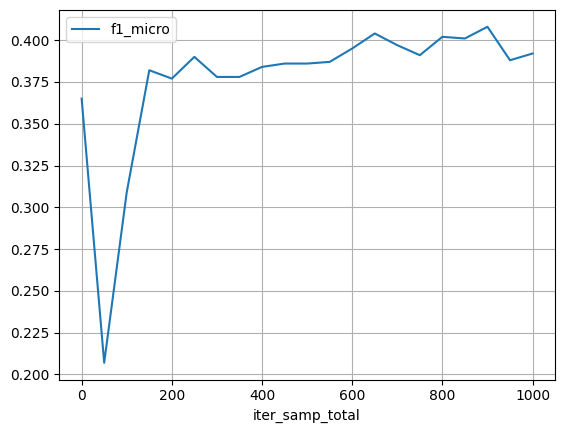

In [24]:
## plot metrics over iterations
metrics_dic_lst = []
n_sample = 0
for key_iter, value_metrics_dic in learner.metrics.items():
    metrics_dic_iter = {key: value_metrics_dic[key] for key in value_metrics_dic if key not in ["eval_label_gold_raw", "eval_label_predicted_raw"]}
    metrics_dic_iter = {"iter_samp_total": n_sample, **metrics_dic_iter}
    metrics_dic_lst.append(metrics_dic_iter)
    n_sample += N_SAMPLE_AL

df_metrics = pd.DataFrame(metrics_dic_lst)

df_metrics.plot(x="iter_samp_total", y="f1_micro", grid=True)
#df_metrics.plot(x="iter_samp_total", y="f1_macro", grid=True)
#df_metrics.plot(x="iter_samp_total", y="eval_accuracy_balanced")



In [25]:
## merge predictions from learner with df_corpus and all meta-data
# get idx for last tested corpus for getting full df_corpus with all columns
df_corpus_test = df_corpus[df_corpus.index.isin(list(set(learner.dataset["corpus"]["idx"])))]
df_corpus_test["label_pred"] = learner.iteration_label_predicted
# add probabilities, e.g. for data cleaning and interpretation downstream
df_corpus_test["label_probabilities"] = learner.iteration_probabilities
df_corpus_train = df_corpus[~df_corpus.index.isin(list(set(learner.dataset["corpus"]["idx"])))]

df_corpus_concat = pd.concat([df_corpus_train, df_corpus_test])

# inspect predictions on test set
df_corpus_test[['label_text', 'label_pred', 'label_probabilities', "text_prepared"]]  # 'label_text_pred',

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-25-5427059b2c85>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corpus_test["label_pred"] = learner.iteration_label_predicted
<ipython-input-25-5427059b2c85>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,label_text,label_pred,label_probabilities,text_prepared
idx,,,,
125137,2012,unanswerable,-0.000501,Context: It threatened the collapse of large f...
30275,Amnesia,unanswerable,-0.002589,Context: But house was also being developed on...
39176,unanswerable,16th century,-0.000971,Context: Although Calvin and Huldrych Zwingli ...
44136,unanswerable,unanswerable,-0.002470,Context: The Queen addressed the United Nation...
70157,it was amended in 1989 and 2003,1989 and 2003,-0.000654,Context: The Constitution of Bermuda came into...
...,...,...,...,...
76627,1994,in 1994,-0.002026,"Context: In South Africa, a ""two apex"" system ..."
114023,1996,1996,-0.000932,Context: The growth in women's football has se...
127693,Basilica of the Sacred Heart,The Basilica of Our Lady of Lourdes,-0.008517,"Context: Because of its Catholic identity, a n..."
